---
---
---

# BraTS - Tumor Subregions Across MRI Modalities 🔬

**Objective**: Explore multi-modal MRI slices and investigate tumor subregions to build a foundational understanding of the BraTS dataset and prepare for the modeling pipeline.


---
---
---

---

## 1. Setup 📦

---

In [1]:
# Data Management
import glob
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.util import montage
from skimage.transform import rotate as roate

# Computational Modules
import math
from scipy.stats import norm, zscore

# Utilities
from google.colab import drive
import h5py
from IPython.display import display, HTML, IFrame, Image
import os
from pathlib import Path
import random
import re
from tqdm import tqdm

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)
sns.set_style('darkgrid', {'grid.color':'0.9', 'xtick.bottom':True, 'ytick.left':True})


---

## 2. Data Access 📂

---

In [2]:
# Define project root
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Define file paths relative to drive structure
data_path = '/content/drive/MyDrive/BraTS_Data/BraTS2020_training_data/content/data'
meta_data_path = '/content/drive/MyDrive/BraTS_Data/BraTS2020_training_data/content/data/meta_data.csv'
name_mapping_path = '/content/drive/MyDrive/BraTS_Data/BraTS2020_training_data/content/data/name_mapping.csv'
survival_info_path = '/content/drive/MyDrive/BraTS_Data/BraTS2020_training_data/content/data/survival_info.csv'
slice_paths = sorted(glob.glob(os.path.join(data_path, '*.h5')))  # get all .h5 files

In [13]:
# Load CSVs into local dataframes
meta_data_df = pd.read_csv(meta_data_path)
name_mapping_df = pd.read_csv(name_mapping_path)
survival_info_df = pd.read_csv(survival_info_path)

In [14]:
# Check paths
print('Exists:', os.path.exists(data_path))
print('Example files:', os.listdir(data_path)[:5])

Exists: True
Example files: ['volume_94_slice_68.h5', 'volume_94_slice_69.h5', 'volume_93_slice_80.h5', 'volume_94_slice_102.h5', 'volume_94_slice_40.h5']


---

## 3. Cursory Explorations 🔍

---


#### **3a. Inspect the structure and contents of the BraTS CSV files.**

In [15]:
# Examine the metadata CSV
display(meta_data_df.head())
print()
display(meta_data_df.info())

,slice_path,target,volume,slice
0,/content/data/volume_41_slice_0.h5,0,41,0
1,/content/data/volume_41_slice_1.h5,0,41,1
2,/content/data/volume_41_slice_2.h5,0,41,2
3,/content/data/volume_41_slice_3.h5,0,41,3
4,/content/data/volume_41_slice_4.h5,0,41,4



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57195 entries, 0 to 57194
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   slice_path  57195 non-null  object
 1   target      57195 non-null  int64 
 2   volume      57195 non-null  int64 
 3   slice       57195 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.7+ MB


None

Each row of the metadata CSV corresponds to a single MRI slice, with columns specifying:

- `slice_path`: File path to the HDF5 slice
- `target`: Binary label indicating presence or absence of tumor within that specific slice
- `volume`: Patient identifier
- `slice`: Specific slice index within the volume

In total, there are 57,195 slices spanning multiple patients. All columns are complete with no missing values, confirming that the dataset is well-structured and the individual slices are ready for further inspection.

In [16]:
# Examine the name mapping CSV
display(name_mapping_df.head())
print()
display(name_mapping_df.info())

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Grade                  369 non-null    object
 1   BraTS_2017_subject_ID  285 non-null    object
 2   BraTS_2018_subject_ID  285 non-null    object
 3   TCGA_TCIA_subject_ID   167 non-null    object
 4   BraTS_2019_subject_ID  335 non-null    object
 5   BraTS_2020_subject_ID  369 non-null    object
dtypes: object(6)
memory usage: 17.4+ KB


None

This CSV provides a mapping between patient IDs across different BraTS releases (2017–2020) and the corresponding tumor grade. Not all patients appear in every dataset release, which explains the presence of missing values in some columns.

This mapping is useful for cross-referencing patients across years and for linking metadata (like tumor grade) to MRI slices in the current dataset. However, this project will stick strictly to the singular 2020 version.

In [17]:
# Examine the survival info CSV
display(survival_info_df.head())
print()
display(survival_info_df.info())

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brats20ID            236 non-null    object 
 1   Age                  236 non-null    float64
 2   Survival_days        236 non-null    object 
 3   Extent_of_Resection  129 non-null    object 
dtypes: float64(1), object(3)
memory usage: 7.5+ KB


None

The survival dataset provides clinically relevant information:

- `Brats20ID`: Patient identifier matching the 2020 MRI data
- `Age`: Patient age at the time of imaging
- `Survival_days`: Overall survival in days (stored as object, may need conversion to numeric)
- `Extent_of_Resection (EOR)`: Surgical outcome indicating how much of the tumor was removed (e.g., GTR = gross total resection)

This data links the imaging to clinical outcomes, which can be useful for downstream analyses or modeling that considers patient characteristics. However, there are missing values within the EOR data, reflecting incomplete surgical records that potentially need to be addressed before using these features for modeling.

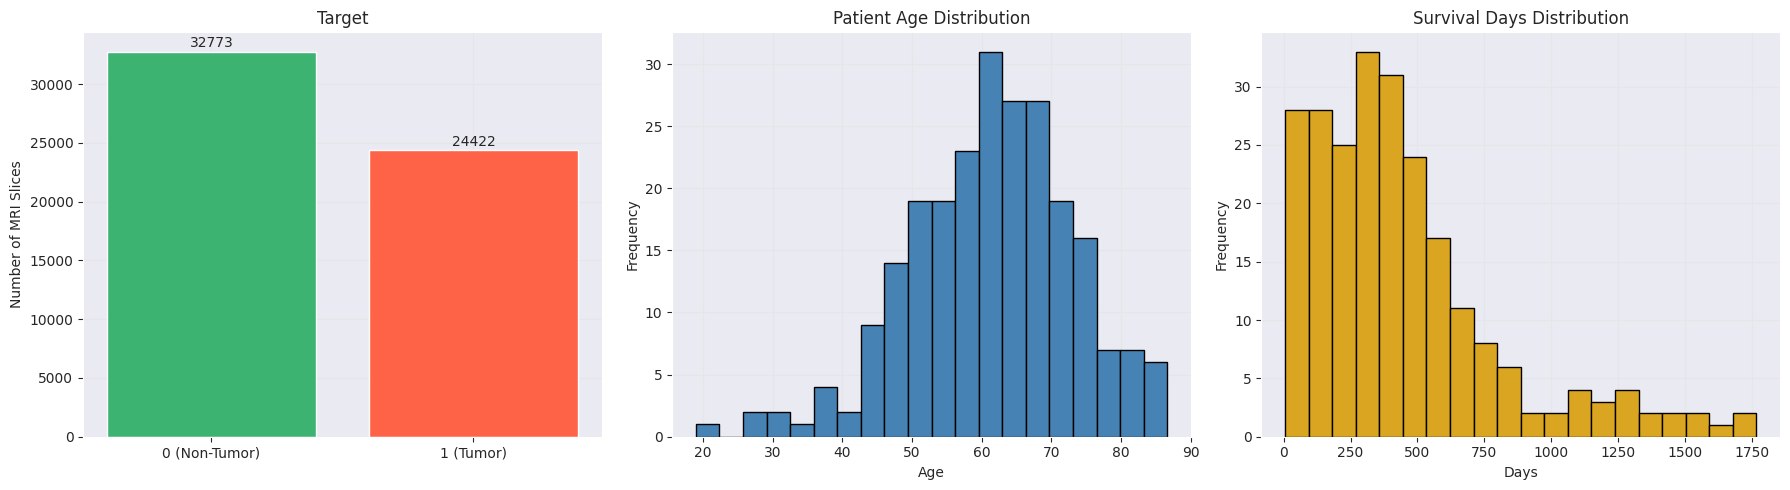

In [18]:
# Set up figure
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# -----------------------------
# Target (Tumor vs. Non-Tumor)
# -----------------------------

# Extract target label counts for plot
target_counts = meta_data_df['target'].value_counts().sort_index()

# Distribution of target across the MRI slices
tgt_bars = axs[0].bar(target_counts.index.astype(str), target_counts.values, color=['mediumseagreen', 'tomato'])

# Add counts above bars
for bar in tgt_bars:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2, height + 100, f'{int(height)}', ha='center', va='bottom')

# Labeling & Formatting
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['0 (Non-Tumor)', '1 (Tumor)'])
axs[0].set_title('Target')
axs[0].set_ylabel('Number of MRI Slices')

# -----------------------------
# Patient Age Distribution
# -----------------------------

# Distribution of patient ages across dataset
axs[1].hist(survival_info_df['Age'].dropna(), bins=20, color='steelblue', edgecolor='black')

# Labeling & Formatting
axs[1].set_title('Patient Age Distribution')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')

# -----------------------------
# Survival Outcomes
# -----------------------------

# Convert survival info to appropriate data type
survival_info_df['Survival_days'] = pd.to_numeric(survival_info_df['Survival_days'], errors='coerce')

# Distribution of survival days across dataset
axs[2].hist(survival_info_df['Survival_days'].dropna(), bins=20, color='goldenrod', edgecolor='black')

# Labeling & Formatting
axs[2].set_title('Survival Days Distribution')
axs[2].set_xlabel('Days')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


**Target**

The dataset contains both non-tumor (0) and tumor (1) cases. Non-tumor samples are more frequent, indicating a moderate class imbalance that should be considered during data split process, model training, and evaluation.

**Patient Age**

Patient ages span roughly from early adulthood to the mid-80s, with most cases concentrated between 50 and 75 years. The distribution peaks around early 60s.

**Survival Days**

Survival times are right-skewed as most patients fall within the lower survival range (under ~600 days), with fewer long-term survivors extending beyond 1000 days.

#### **3b. Examine imaging data and channel composition.**

In [19]:
# Total number of image slices in dataset
total_slices = len(slice_paths)

# Extract unique patient IDs from filenames (volume_x_slice_y.h5)
patient_ids = set()
for path in slice_paths:
    filename = os.path.basename(path)
    volume_id = filename.split('_')[1]  # gets patient number
    patient_ids.add(volume_id)

# Total number of patients in dataset
total_patients = len(patient_ids)

print('Total patients:', total_patients)
print('Total slices:', total_slices)
print('Average slices per patient:', total_slices / total_patients)


Total patients: 369
Total slices: 57195
Average slices per patient: 155.0


A quick scan of the MRI data reveals:
- 369 unique patients
- 57,195 total 2D slices
- ~155 slices per patient (on average)

This confirms that the dataset is derived from volumetric MRI scans, with multiple axial slices for each patient.

Because slices from the same patient are highly correlated, future train/validation splits must be performed at the patient level, not the slice level, to prevent data leakage.

The total slice count also helps gauge the training cost and iteration speed on a constrained Colab runtime. For the baseline model (on Colab free-tier), heavy subsetting is required.

In [20]:
# Inspect single slice
ex_vol_num = 238  # other examples (v94, s68) (v87, s68)
ex_slice_num = 67
ex_slice_path = f'/content/drive/MyDrive/BraTS_Data/BraTS2020_training_data/content/data/volume_{ex_vol_num}_slice_{ex_slice_num}.h5'

with h5py.File(ex_slice_path, 'r') as file:
    print('Keys:', list(file.keys()))

    image = file['image'][:]
    mask = file['mask'][:]

    print('Image shape:', image.shape)
    print('Mask shape:', mask.shape)
    print('Image dtype:', image.dtype)
    print('Mask dtype:', mask.dtype)
    print('Mask values:', np.unique(mask))
    print('Max overlapping labels per pixel:', mask.sum(axis=-1).max())

Keys: ['image', 'mask']
Image shape: (240, 240, 4)
Mask shape: (240, 240, 3)
Image dtype: float64
Mask dtype: uint8
Mask values: [0 1]
Max overlapping labels per pixel: 1


An individual slice was randomly selected (via trial & error for downstream visuals) to inspect the structure and encoding of the stored images and masks.

The image tensor has shape (240, 240, 4). The first two dimensions represents a spatial resolution of 240x240 pixels, while the third dimension refers to the channel axis. In this case, each channel is for a single MRI modality: **T1**, **T1Gd**, **T2**, **T2-FLAIR**. In other words, for each pixel location, the input consists a 4-dimensional feature vector capturing intensity values across the four modalities.

The mask tensor has shape (240, 240, 3), indicating a multi-channel segmentation target. Each channel is a binary map to a tumor subregion: necrotic/non-enhancing core (**NEC/NET**), peritumoral edema (**ED**), and enhancing tumor (**ET**). Rather than assigning a single categorical label per pixel, the model will predict three independent binary maps (multi-label formulation). The final check also confirms that the channels are mutually exclusive in this encoding, meaning each pixel belongs to at most one tumor subregion.

The images are stored as *float64* and masks as *uint8* with values {0,1}. During preprocessing, both will be converted to *float32* to reduce memory usage and ensure compatibility with GPU training.

---

## 4. Advanced Explorations 🔬

---

#### **4a. Visualize a sample MRI slice across modalities and verify image-mask alignment.**

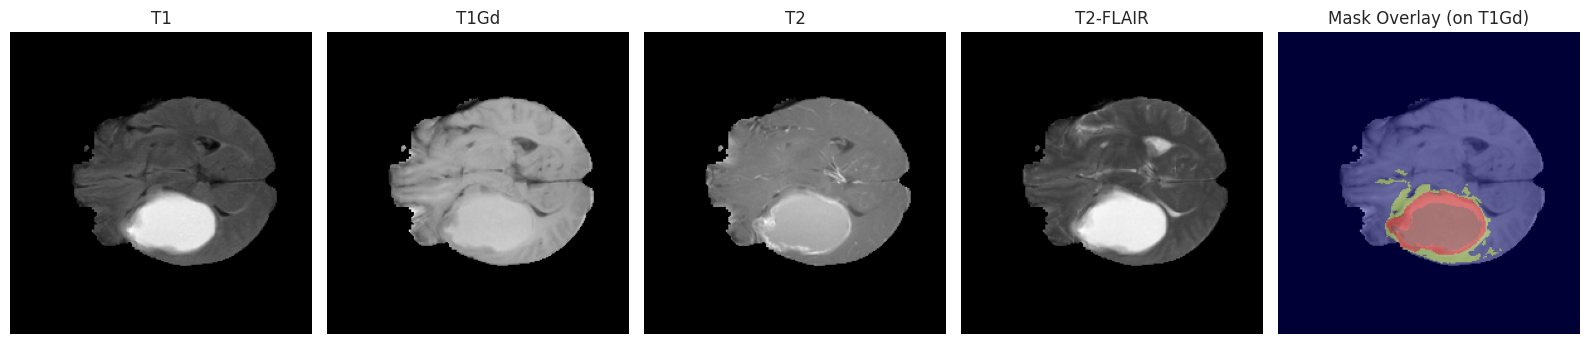

In [21]:
# Define iterable list of MRI modality names
modalities = ['T1', 'T1Gd', 'T2', 'T2-FLAIR']

# Set up figure
fig, axs = plt.subplots(1, 5, figsize=(16, 4))

# Plot all modalities
for i in range(4):
    axs[i].imshow(image[:, :, i], cmap='gray')
    axs[i].set_title(modalities[i])
    axs[i].axis('off')

# Create single visualization mask (assign unique labels per tumor subregion)
combined_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
combined_mask[mask[:, :, 0] == 1] = 1  # NEC/NET
combined_mask[mask[:, :, 1] == 1] = 2  # ED
combined_mask[mask[:, :, 2] == 1] = 3  # ET

# Define custom colormap for displaying each subsection
cmap = mcolors.ListedColormap(['darkblue', 'maroon', 'yellowgreen', 'red'])

# Overlay mask on T1Gd slice
axs[4].imshow(image[:, :, 1], cmap='gray')  # T1Gd as background
axs[4].imshow(combined_mask, cmap=cmap, alpha=0.4)
axs[4].set_title('Mask Overlay (on T1Gd)')
axs[4].axis('off')

plt.tight_layout()
plt.show()

Each slice includes four MRI modalities capturing different tissue characteristics:
- **T1**: baseline anatomical structure
- **T1Gd**: post-contrast scan highlighting enhancing tumor regions
- **T2**: sensitive to fluid content
- **T2-FLAIR**: suppresses CSF signal, improving visibility of edema

All modalities are spatially aligned and share identical dimensions. The segmentation mask, overlaid on the T1Gd image, appears correctly localized relative to visible abnormalities. This confirms proper co-registration, pixel-wise alignment between inputs and masks, and no obvious corruption prior to training.

#### **4b. Visualize a sample MRI slice across planes.**

In [22]:
# Select modality of interest
modality_index = 3  # 0=T1, 1=T1Gd, 2=T2, 3=T2-FLAIR

# Get all slice paths for this patient
patient_slice_paths = [
    p for p in slice_paths
    if f'volume_{ex_vol_num}_' in os.path.basename(p)
]

# Sort slices numerically by slice index
def extract_slice_number(path):
    match = re.search(r'slice_(\d+)', path)
    return int(match.group(1)) if match else -1

patient_slice_paths = sorted(patient_slice_paths, key=extract_slice_number)

# Load all slices for selected modality
volume_slices = []

for path in patient_slice_paths:
    with h5py.File(path, 'r') as f:
        volume_slices.append(f['image'][:, :, modality_index])

# Stack into 3D volume (H, W, num_slices)
volume_3d = np.stack(volume_slices, axis=-1)

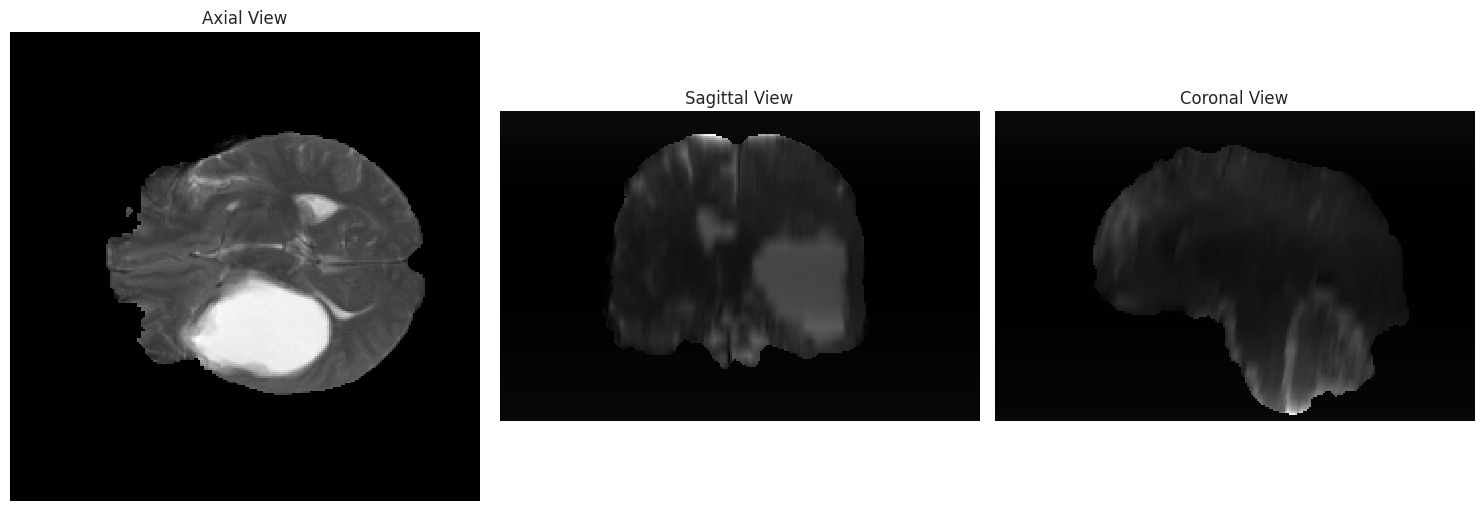

In [23]:
# Axial (standard slice view)
axial_view = volume_3d[:, :, ex_slice_num]

# Sagittal (slice through left-right axis)
sagittal_view = volume_3d[:, volume_3d.shape[1] // 2, :]

# Coronal (slice through front-back axis)
coronal_view = volume_3d[volume_3d.shape[0] // 2, :, :]

# Set up figure & plot each view
plt.figure(figsize=(15, 5))

# Axial (240 x 240)
plt.subplot(1, 3, 1)
plt.imshow(axial_view, cmap='gray', interpolation='nearest')
plt.title('Axial View')
plt.axis('off')

# Sagittal (240 x 155)
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(sagittal_view), cmap='gray', interpolation='nearest')
plt.title('Sagittal View')
plt.axis('off')

# Coronal (240 x 155)
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(coronal_view), cmap='gray', interpolation='nearest')
plt.title('Coronal View')
plt.axis('off')

plt.tight_layout()
plt.show()

Although each sample is being referred to as a “slice,” brain MRIs are inherently three-dimensional and can be viewed from multiple anatomical planes:

- **Axial plane**: A horizontal cross-section taken from top to bottom (most common view)
- **Coronal plane**: A vertical slice dividing the brain into front (anterior) and back (posterior) portions
- **Sagittal plane**: A vertical slice dividing the brain into left and right hemispheres

These anatomical planes are crucial for interpreting MRI data correctly. Each provides a different spatial perspective of the same structures, which helps localize tumors and understand their extent in three dimensions. Even though this project processes slices independently in 2D, the underlying anatomy remains inherently 3D.


#### **4c. Visualize a sample MRI slice across masks.**

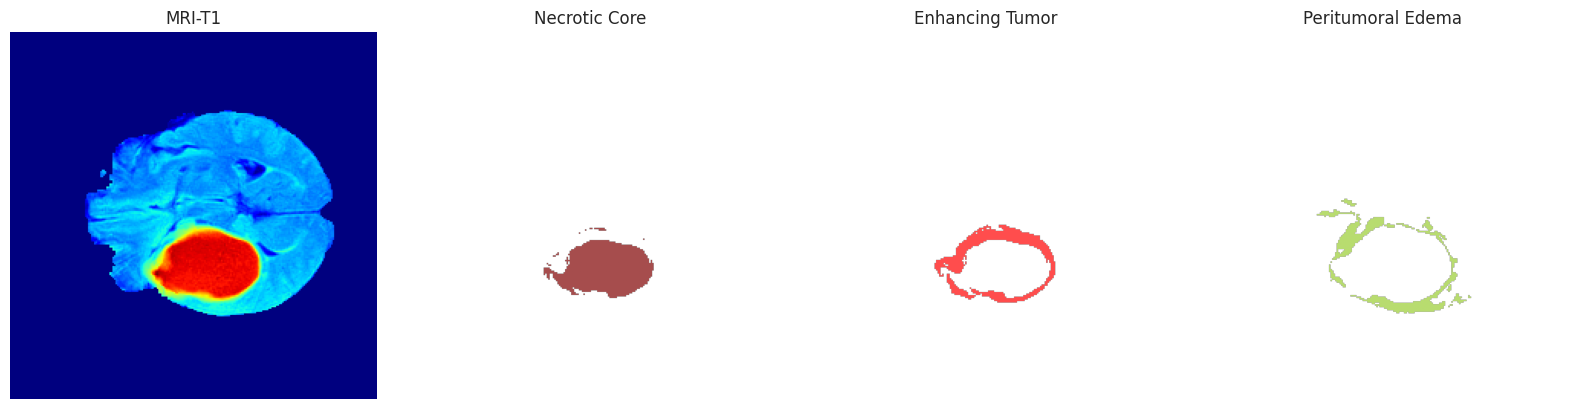

In [24]:
# Combine MRI + mask channels into one iterable
modality_index = 0  # for plain T1
images = [
    image[:, :, modality_index],  # MRI
    mask[:, :, 0],  # NEC/NET (Necrotic/Core)
    mask[:, :, 2],  # ET (Enhancing Tumor)
    mask[:, :, 1],  # ED (Edema)
]

# Define corresponding labels and colors
fig_labels = ['MRI-T1', 'Necrotic Core', 'Enhancing Tumor', 'Peritumoral Edema']
mask_colors = ['jet', 'maroon', 'red', 'yellowgreen']  # first color for MRI

# Set up figure
plt.figure(figsize=(16, 4))

# Plot all subregion labels
for i in range(4):
    plt.subplot(1, 4, i + 1)
    if i == 0:
        plt.imshow(images[i], cmap=mask_colors[0])
    else:
        # Only color pixels where mask==1
        colored_mask = np.ma.masked_where(images[i] == 0, images[i])
        plt.imshow(colored_mask, cmap=mcolors.ListedColormap([mask_colors[i]]), alpha=0.7)
    plt.title(fig_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


The figure shows a single axial T1 slice alongside its corresponding tumor subregion masks:

- **MRI-T1**: Anatomical reference image; tumor appears as a hyperintense region in the lower hemisphere
- **Necrotic Core**: Non-enhancing necrotic tumor core, located centrally within the lesion
- **Enhancing Tumor**: Actively enhancing tumor rim, typically outlining the core
- **Peritumoral Edema**: Surrounding edema extending beyond the enhancing tumor

In this slice, the tumor structure appears heterogeneous with a visible core, peripheral enhancement, and surrounding edema in its typical pattern.

Its also important to keep in mind that this spatial pattern is not expected to be clear in every slice since the displayed volume-slice combination was intentially selected to serve as an example visual. Consequently, a major challenge of this dataset will be a strong class imbalance as the vast majority of pixels correspond to healthy tissue. Instead of a single slice, a high-level visual of all the slices can better illustrate this issue.


#### **4d. Visualize a full MRI scan for single patient.**

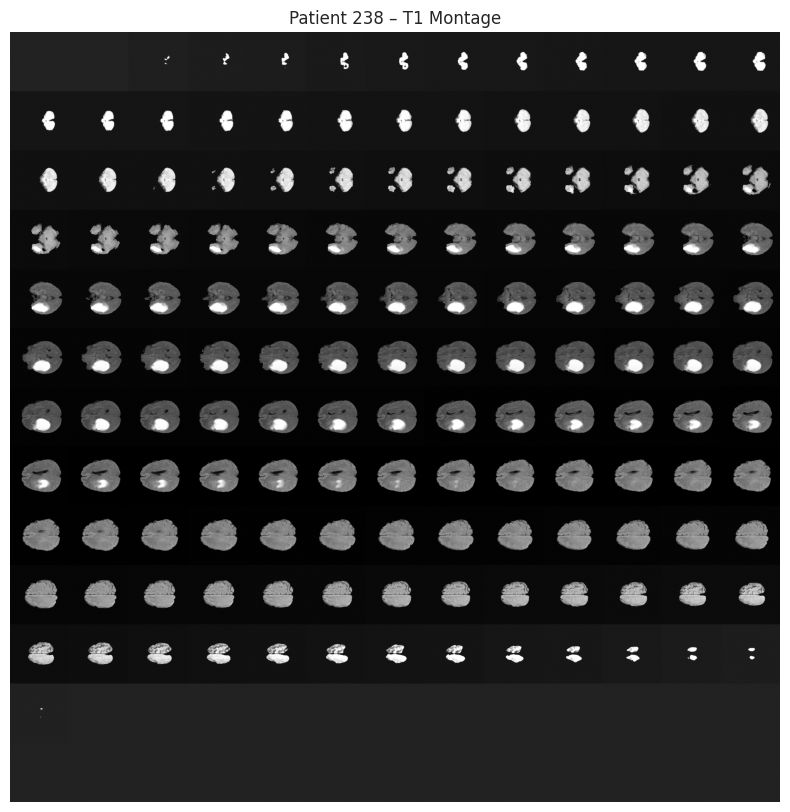

In [25]:
# Select modality of interest
modality_index = 0  # 0=T1, 1=T1Gd, 2=T2, 3=T2-FLAIR

def extract_slice_number(path):
    """Extract and sort all slices belonging to the selected patient."""
    match = re.search(r'slice_(\d+)', path)
    return int(match.group(1)) if match else -1

ex_patient_slices = sorted(
    [p for p in slice_paths if f'volume_{ex_vol_num}_' in p],
    key=extract_slice_number
)

# Load selected modality for all slices; resulting shape: (num_slices, height, width)
volume = []
for path in ex_patient_slices:
    with h5py.File(path, 'r') as f:
        volume.append(f['image'][:, :, modality_index])
volume = np.stack(volume, axis=0)

# Robust intensity normalization (prevents outliers from washing out contrast)
vmin = np.percentile(volume, 1)
vmax = np.percentile(volume, 99)
volume = np.clip(volume, vmin, vmax)
volume = (volume - vmin) / (vmax - vmin)

# Tile slices into a single 2D grid for visual
montage_img = montage(volume)

# Set up and output the montage
plt.figure(figsize=(10, 10))
plt.imshow(montage_img, cmap='gray', vmin=0, vmax=1)
plt.title(f'Patient {ex_vol_num} – T1 Montage')
plt.axis('off')
plt.show()


As shown in the montage of axial slices for a single patient, many slices contain little or no visible tumor, despite the prevalent tumor identified from the single slice examination from the previous code blocks. The tumor is apparent only across a subset of contiguous slices, while the remainder represent healthy tissue.

This further illustrates the class imbalance inherent to MR imaging data. The next step is to quantify this imbalance across a larger subset to guide loss selection and training strategy.

#### **4e. Quantify pixel-level class imbalance across tumor subregions.**

In [26]:
# Use a subset of slices for a quicker scan
num_samples = 100
subset_paths = slice_paths[:num_samples]

# Initialize counters for loop
total_pixels = 0                  # Total number of pixels across all slices
tumor_counts = np.zeros(3)        # Accumulates tumor pixels per channel

for file_path in tqdm(subset_paths):

    # Load mask only (image not needed for class distribution analysis)
    with h5py.File(file_path, 'r') as file:
        mask = file['mask'][:]

    # Accumulate total pixel count (height × width per slice)
    total_pixels += mask.shape[0] * mask.shape[1]

    # Count positive pixels per channel (tumor subregion)
    for i in range(3):
        tumor_counts[i] += np.sum(mask[:, :, i] > 0)

# Compute and print percentage of pixels occupied by each tumor type
for i, name in enumerate(['Necrotic Core', 'Peritumoral Edema', 'Enhancing Tumor']):
    percentage = 100 * tumor_counts[i] / total_pixels
    print(f'\n{name}: {percentage:.3f}% of pixels')


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Necrotic Core: 0.034% of pixels

Peritumoral Edema: 0.129% of pixels

Enhancing Tumor: 0.012% of pixels


Across a sample of 100 slices, tumor regions occupy only a tiny fraction of the image area. Peritumoral edema is the most prevalent class, while enhancing tumor and necrotic core appear even less frequently. Overall, the vast majority of pixels (>99%) correspond to background.

This highlights the severe class imbalance inherent to brain tumor segmentation. A naive model could achieve high pixel accuracy by predicting background almost everywhere, despite failing to capture the clinically meaningful regions. For this reason, overlap-based metrics such as the Dice coefficient are more appropriate than raw accuracy for evaluating model performance in this project.

In addition to understanding class imbalance across tumor subregions, it is also important to examine the range and variability of MRI intensities. This helps identify the need for normalization before training, ensuring that the network sees inputs on a consistent scale.

#### **4f. Conduct intensity distribution analysis across slices.**

In [27]:
# Select the MRI modality we want to analyze
modality_index = 0  # 0=T1, 1=T1Gd, 2=T2, 3=T2-FLAIR

# Use a small subset of slices to speed up computation
num_samples = 100
subset_paths = slice_paths[:num_samples]

# Initialize lists to collect summary statistics for each slice
intensity_mins = []
intensity_maxs = []
intensity_means = []
intensity_stds = []

# Flattened pixel intensities across all slices for histogram plotting
all_pixels = []

# Loop through the subset of slices
for path in tqdm(subset_paths):
    # Load the slice and extract the selected modality
    with h5py.File(path, 'r') as f:
        img = f['image'][:, :, modality_index]

    # Collect min, max, mean, and std of this slice
    intensity_mins.append(img.min())
    intensity_maxs.append(img.max())
    intensity_means.append(img.mean())
    intensity_stds.append(img.std())

    # Store all pixels flattened for overall histogram
    all_pixels.append(img.flatten())

# Concatenate pixel values from all sampled slices
all_pixels = np.concatenate(all_pixels)

# Print summary statistics across the subset
print('Intensity Statistics Across Sampled Slices:\n')
print(f'Min intensity range: {min(intensity_mins):.2f} to {max(intensity_mins):.2f}')
print(f'Max intensity range: {min(intensity_maxs):.2f} to {max(intensity_maxs):.2f}')
print(f'Mean intensity range: {min(intensity_means):.2f} to {max(intensity_means):.2f}')
print(f'Std deviation range: {min(intensity_stds):.2f} to {max(intensity_stds):.2f}')


100%|██████████| 100/100 [00:00<00:00, 101.65it/s]


Intensity Statistics Across Sampled Slices:

Min intensity range: -0.52 to 0.00
Max intensity range: 0.00 to 132.75
Mean intensity range: -0.00 to 0.00
Std deviation range: 0.00 to 1.00


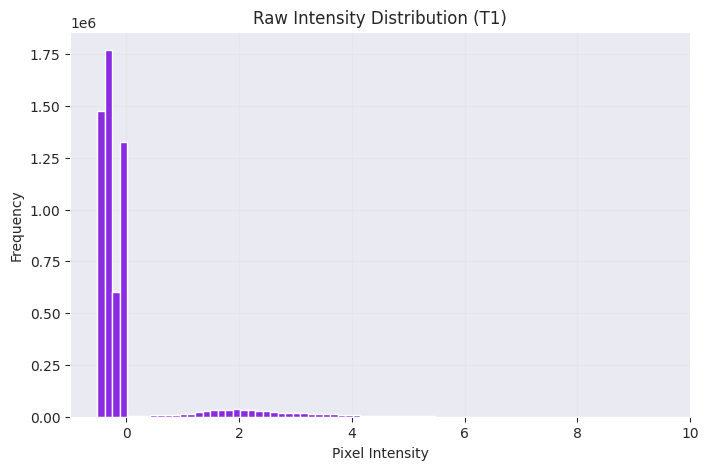

In [28]:
# Set up figure
plt.figure(figsize=(8,5))

# Plot histogram of raw pixel intensities across all slices
plt.hist(all_pixels, bins=1000, color='blueviolet')

# Formatting & Labeling
plt.title('Raw Intensity Distribution (T1)')
plt.xlim(-1, 10)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

The raw intensity statistics highlight substantial variability across slices. Minimum values range from slightly negative to 0, while maximum values can exceed 130. The mean intensity hovers near zero, and standard deviations vary up to 1.0. This confirms that MRI intensities are not standardized across slices. Unlike natural images, pixel values are influenced by scanner settings and acquisition protocols.

Without normalization, the model would need to learn both anatomical structure and arbitrary intensity scaling, which could slow convergence and reduce generalization. These results reinforce that intensity normalization is a necessary preprocessing step before training.

#### **4g. Conduct intensity distribution analysis across patients.**

In [29]:
# Select MRI modality to examine (0=T1, 1=T1Gd, 2=T2, 3=FLAIR)
modality_index = 0

# Define number of patients to sample for this quick check
num_patients_to_sample = 20

# Pick the first N patient IDs from the dataset
sampled_patients = list(patient_ids)[:num_patients_to_sample]

# Initialize lists to collect per-patient intensity stats
means = []
stds = []
mins = []
maxs = []

# Loop over selected patients
for patient_id in sampled_patients:

    # Grab one representative slice for this patient (first slice found)
    patient_slice = next(
        p for p in slice_paths
        if f'volume_{patient_id}_' in p
    )

    # Load the slice
    with h5py.File(patient_slice, 'r') as f:
        img = f['image'][:, :, modality_index]

    # Compute and store basic intensity statistics
    means.append(img.mean())
    stds.append(img.std())
    mins.append(img.min())
    maxs.append(img.max())

# Print summary statistics across sampled patients
print("Across sampled patients (single slice each):")
print(f"Mean intensity range: {min(means):.2f} to {max(means):.2f}")
print(f"Std intensity range: {min(stds):.2f} to {max(stds):.2f}")
print(f"Min value range: {min(mins):.2f} to {max(mins):.2f}")
print(f"Max value range: {min(maxs):.2f} to {max(maxs):.2f}")

Across sampled patients (single slice each):
Mean intensity range: -0.00 to 0.00
Std intensity range: 0.00 to 1.00
Min value range: -0.24 to 0.00
Max value range: 0.00 to 153.51


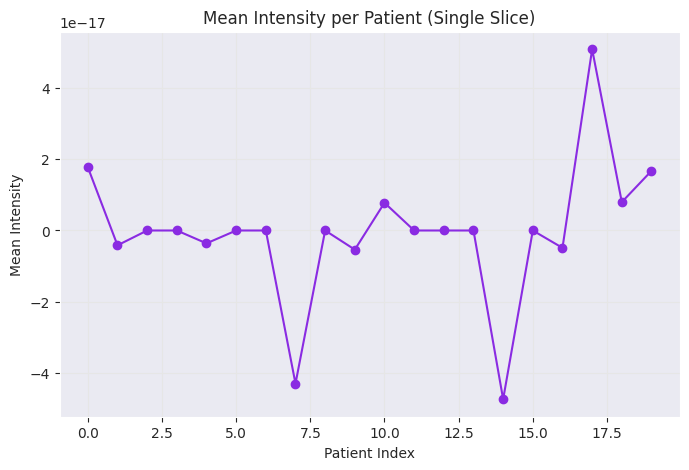

In [30]:
# Set up figure
plt.figure(figsize=(8,5))

# Visualize variation of mean intensity across patients
plt.plot(means, marker='o', color='blueviolet')

# Formatting & Labeling
plt.title('Mean Intensity per Patient (Single Slice)')
plt.xlabel('Patient Index')
plt.ylabel('Mean Intensity')
plt.show()

Checking intensity across a subset of patients highlights the variability across the samples. Even though the mean intensity values appear close to zero due to prior clipping/centering, the standard deviations, minima, and maxima vary considerably between patients. For example, the max intensity ranges from 0 to 113, and the min ranges from -0.22 to 0.

This variation reflects differences in scanner settings, acquisition protocols, and patient-specific factors. Consequently, raw MRI intensities are not directly comparable across subjects.

#### **4h. Conduct intensity distribution analysis across imaging modalities.**

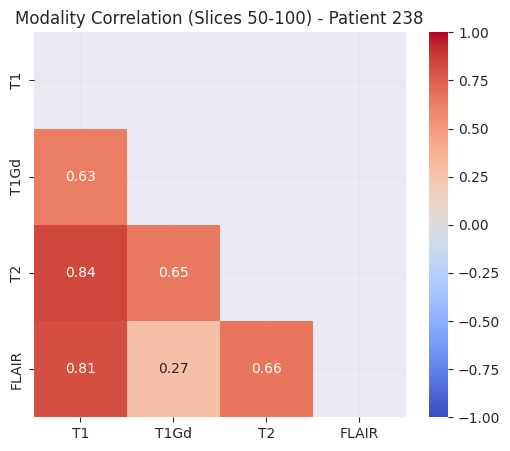

In [31]:
# Define iterable for MRI modalities
modality_names = ['T1', 'T1Gd', 'T2', 'FLAIR']

# Define slice range to use for each patient (focusing on the main middle third)
start_slice = 50
end_slice = 100

# Extract slice paths for example patient from earlier visuals
ex_patient_slices = sorted(
    [p for p in slice_paths if f'volume_{ex_vol_num}_' in p],
    key=extract_slice_number
)

# Gather all 4 modalities
subset_volume = []
for path in ex_patient_slices[start_slice:end_slice]:
    with h5py.File(path, 'r') as f:
        subset_volume.append(f['image'][:, :, :4])  # all 4 modalities

subset_volume = np.stack(subset_volume, axis=0)  # shape: (num_slices, H, W, 4)

# Reshape to (num_pixels, num_modalities)
num_slices, H, W, C = subset_volume.shape
flat_pixels = subset_volume.reshape(num_slices * H * W, C)

# Mask out background pixels (all zeros)
brain_mask = np.any(flat_pixels > 0, axis=1)
flat_pixels = flat_pixels[brain_mask]

# Compute correlation
corr_matrix = np.corrcoef(flat_pixels, rowvar=False)

# Set up figure
plt.figure(figsize=(6,5))

# Plot heatmap of intensities across modalities
sns.heatmap(
    corr_matrix,
    mask=np.triu(np.ones_like(corr_matrix, dtype=bool)),
    annot=True,
    xticklabels=modality_names,
    yticklabels=modality_names,
    cmap='coolwarm',
    vmin=-1, vmax=1
)

# Formatting & Labeling
plt.title(f'Modality Correlation (Slices {start_slice}-{end_slice}) - Patient {ex_vol_num}')

plt.show()


The correlation matrix shows how the four MRI modalities relate in terms of intensity. Only slices 50–100 for the example patient were used to focus the analysis on the middle-third portion of the slice set which contains the primary brain imaging.

- T1 is strongly correlated with T2 (0.84) and T2-FLAIR (0.81)
- T1Gd behaves differently, with moderate correlation to T1/T2 and weak correlation to T2-FLAIR (0.27)
- T2 and T2-FLAIR share some information (0.66) but differ due to edema/FLAIR-specific signals

These patterns highlight that although the modalities are largely carry overlapping intensities, there are notable differences between contrast-based imaging and T2-FLAIR. This suggests these two modalities may serve as complementary features, making them good candidates for a baseline model where computational efficiency is crucial.